# MIMIC-III queries on the ICD-9 system
In this part we are looking at the ICD-9 system (International Classification of Disease), an official system to assign codes to diagnoses and procedures. We will first look into two queries with a specific diagnosis, namely hypertension. Afterwards, we will look into the distribution of ICD-9 codes across intensive care units.

In [1]:
#imports:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mc
import colorsys
import psycopg2
%matplotlib inline
# Configuration:
sqluser = 'postgres'
dbname = 'mimic'
password='postgres'
schema_name = 'mimiciii'
# Connect to MIMIC-III:
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

### 1. Number of patients diagnosed with hypertension above 30 years old
First, we would like to count the number of patients who were diagnosed with hypertension and are at least 30 years old. In this case we are looking for the ICD-9 code that corresponds to hypertension, so we will first find the correct code and then perform our query. The ICD-9 codes that we will use are 4010, 4011 and 4019. <br>

___SQL query description___

The diagram to obtain this number is shown below. First, we need to combine the Admissions and Patients table to obtain the age (from date of birth and admission time), and filter out all patients younger than 30 years old. ICD9 diagnoses can be found in the Diagnoses_icd table (and descriptions of each code can be found in the D_icd_diagnoses table). We select all ICD-9 codes that are starting with 401, as these are related to hypertension.
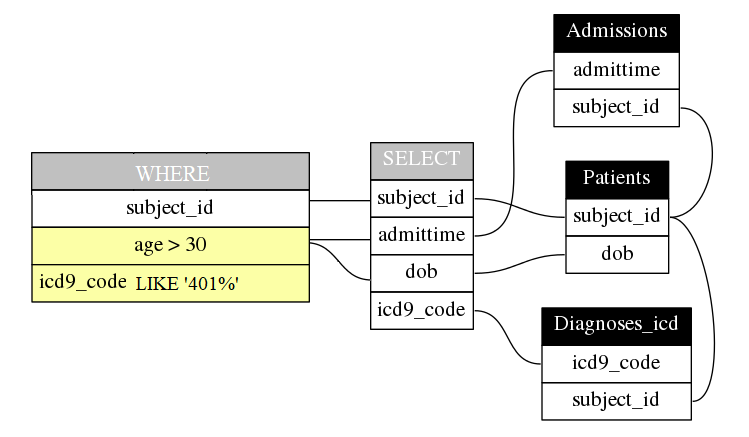

In [2]:
# First make sure we select the right itemids:
query ="""
SELECT d.icd9_code, d.long_title
FROM mimiciii.d_icd_diagnoses d
WHERE d.long_title LIKE '%essential hypertension%'
"""

query_output = pd.read_sql_query(query,con)
query_output

,icd9_code,long_title
0,4010,Malignant essential hypertension
1,4011,Benign essential hypertension
2,4019,Unspecified essential hypertension
3,64200,Benign essential hypertension complicating pre...
4,64201,Benign essential hypertension complicating pre...
5,64202,"Benign essential hypertension, complicating pr..."
6,64203,Benign essential hypertension complicating pre...
7,64204,Benign essential hypertension complicating pre...


In [3]:
query ="""
SELECT COUNT(DISTINCT p.subject_id) 
FROM mimiciii.patients p
INNER JOIN mimiciii.admissions a ON p.subject_id = a.subject_id
INNER JOIN mimiciii.diagnoses_icd diag ON p.subject_id = diag.subject_id
WHERE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) > 30 AND diag.icd9_code LIKE '401%';
"""

query_output = pd.read_sql_query(query,con)
query_output.head()

,count
0,17916


### 2. Histogram of the number of patients diagnosed with hypertension
Next, instead of counting the number of patients diagnosed with hypertension of 30 years and older, we would also like to see the distribution of hypertension diagnoses across different age groups for all ages. Hence, we do not want to filter out any age ranges. 
___SQL query description___
The approach is very similar to the previous query. However, we now do not filter on age, and also select the age for each patient, to be able to create a histogram across different age ranges.
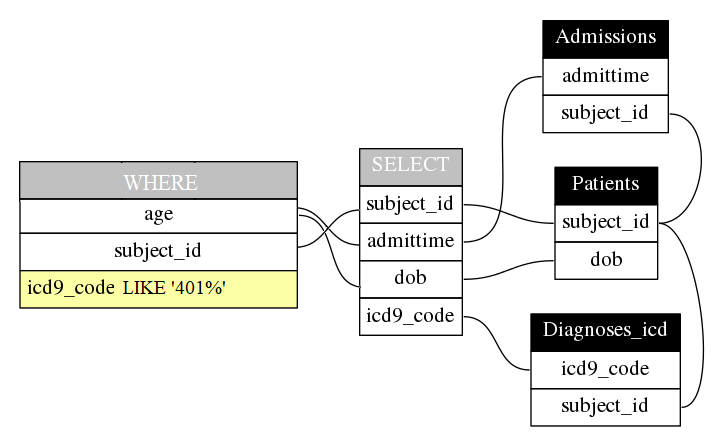

In [10]:
query ="""
WITH hypertension_table AS(
    SELECT DISTINCT diag.subject_id, a.admittime
    FROM mimiciii.diagnoses_icd diag
    INNER JOIN mimiciii.admissions a ON diag.subject_id = a.subject_id
    WHERE diag.icd9_code LIKE '401%'
    ORDER BY diag.subject_id),
    age_table AS (
    SELECT p.subject_id,round((EXTRACT(EPOCH FROM (h.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age
    FROM mimiciii.patients p
    INNER JOIN hypertension_table h ON h.subject_id = p.subject_id
    )
SELECT COUNT(*) AS TOTAL,
       COUNT(CASE WHEN age >= 0 AND age < 16 THEN  '0 - 15' END) AS "0-15",
       COUNT(CASE WHEN age >= 16 AND age < 21 THEN '16 - 20' END) AS "16-20",
       COUNT(CASE WHEN age >= 21 AND age < 26 THEN '21 - 25' END) AS "21-25",
       COUNT(CASE WHEN age >= 26 AND age < 31 THEN '26 - 30' END) AS "26-30",
       COUNT(CASE WHEN age >= 31 AND age < 36 THEN '31 - 35' END) AS "31-35",
       COUNT(CASE WHEN age >= 36 AND age < 41 THEN '36 - 40' END) AS "36-40",
       COUNT(CASE WHEN age >= 41 AND age < 46 THEN '41 - 45' END) AS "41-45",
       COUNT(CASE WHEN age >= 46 AND age < 51 THEN '46 - 50' END) AS "46-50",
       COUNT(CASE WHEN age >= 51 AND age < 56 THEN '51 - 55' END) AS "51-55",
       COUNT(CASE WHEN age >= 56 AND age < 61 THEN '56 - 60' END) AS "56-60",
       COUNT(CASE WHEN age >= 61 AND age < 66 THEN '61 - 65' END) AS "61-65",
       COUNT(CASE WHEN age >= 66 AND age < 71 THEN '66 - 70' END) AS "66-70",
       COUNT(CASE WHEN age >= 71 AND age < 76 THEN '71 - 75' END) AS "71-75",
       COUNT(CASE WHEN age >= 76 AND age < 81 THEN '76 - 80' END) AS "76-80",
       COUNT(CASE WHEN age >= 81 AND age < 86 THEN '81 - 85' END) AS "81-85",
       COUNT(CASE WHEN age >= 86 AND age < 91 THEN '86 - 90' END) AS "86-91",
       COUNT(CASE WHEN age >= 91 THEN 'Over 91' END) AS ">91"
FROM age_table;
"""

query_output = pd.read_sql_query(query,con)

<ipython-input-11-f20ddd903adf>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  counts = pd.Series([])


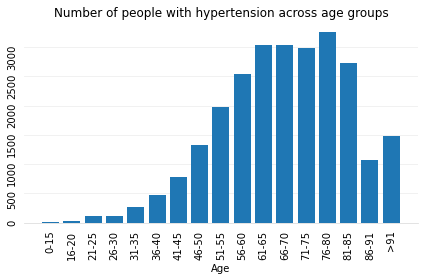

In [11]:
# Visualize with a bar chart:
labels = ['0-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '66-70',
          '71-75', '76-80', '81-85', '86-91', '>91']
counts = pd.Series([])
for label in labels:
    counts = counts.append(query_output[label])
    
fig, ax = plt.subplots()
bars = ax.bar(labels, counts)
plt.xlabel('Age')
plt.title('Number of people with hypertension across age groups')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False, rotation = 90)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
plt.tight_layout()
fig.savefig('figures/icd9_age_groups_histogram.jpg', dpi=400)

### 3. Most common ICD-9 codes across adult patients
We are interested in the ICD-9 codes sorted by their frequency, and want to select to five ICD-9 codes with the highest frequencies. We are only interested to see these results for adult (age >= 16) patients who have been admitted to the ICU. 

___SQL query description___

The diagram below visualizes how we can obtain these ICD-9 codes. First, we combine the Patients and Admissions tables to obtain each patient’s age at time of hospital admission from their date of birth and hospital admission time. We also combine the Icustays tables, to filter out any patients who were not admitted to the ICU. We join the Diagnoses_icd¬ and D_icd_diagnoses¬ tables to get all ICD-9 codes and their descriptions. From the Diagnoses_icd table, we also take into account the priority of each ICD-9 code, as hospital admissions might correspond to multiple ICD-9 codes, but we are only interested in the primary diagnosis.
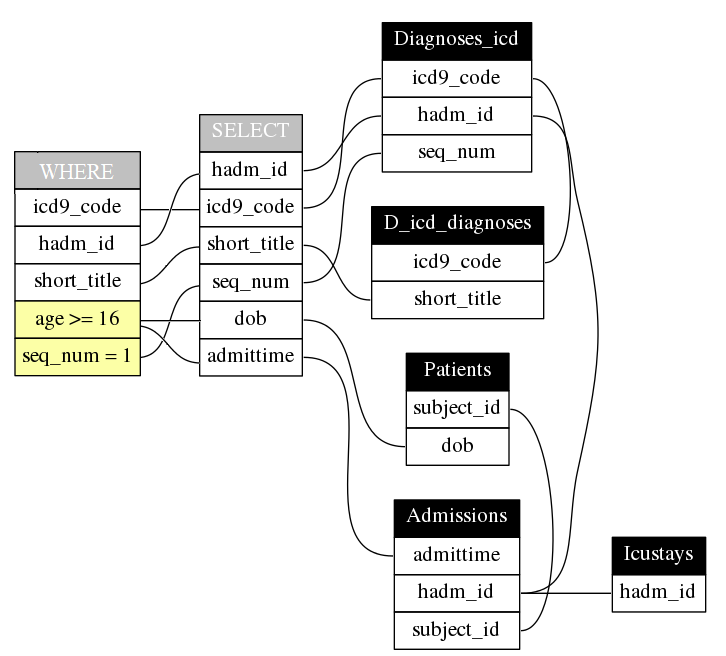

In [13]:
query ="""
SELECT diag.hadm_id, diag.icd9_code, d_icd.short_title
FROM mimiciii.patients p
INNER JOIN mimiciii.admissions a ON p.subject_id = a.subject_id
INNER JOIN mimiciii.diagnoses_icd diag ON a.hadm_id = diag.hadm_id
INNER JOIN mimiciii.d_icd_diagnoses d_icd ON diag.icd9_code = d_icd.icd9_code
INNER JOIN mimiciii.icustays i ON a.hadm_id = i.hadm_id
WHERE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16
AND diag.seq_num = 1
"""

query_output = pd.read_sql_query(query, con)
print('ICD-9 codes and their frequencies: ')
print(query_output.drop_duplicates(['hadm_id'])['icd9_code'].value_counts().head())

print('Or in percentages of all diagnoses: ')
print(query_output.drop_duplicates(['hadm_id'])['icd9_code'].value_counts().head() /
      len(query_output.drop_duplicates(['hadm_id'])['icd9_code']) * 100)

most_frequent_icd9s = np.array(query_output.drop_duplicates(['hadm_id'])['icd9_code'].value_counts().head().index.values)
query_output.loc[query_output['icd9_code'].isin(most_frequent_icd9s)].drop_duplicates(['icd9_code']).drop('hadm_id', axis=1)

ICD-9 codes and their frequencies: 
41401    3496
0389     2069
41071    1751
4241     1140
51881    1127
Name: icd9_code, dtype: int64
Or in percentages of all diagnoses: 
41401    7.122629
0389     4.215309
41071    3.567427
4241     2.322596
51881    2.296111
Name: icd9_code, dtype: float64


,icd9_code,short_title
4,41401,Crnry athrscl natve vssl
11,4241,Aortic valve disorder
45,0389,Septicemia NOS
53,41071,"Subendo infarct, initial"
73,51881,Acute respiratry failure


### 4. Distribution of ICD-9 codes across care units
ICD-9 codes can be grouped into 9 larger categories (10 if we have an ‘other’ category):

- (001-139): Infectious and parasitic diseases, i.e., septicemia, other infectious and parasitic diseases, etc.
- (139-239): Neoplasms of digestive organs and intrathoracic organs, etc.
- (240-279): Endocrine, nutritional, metabolic, and immunity.
- (390-459): Diseases of the circulatory system, i.e., ischemic heart diseases, diseases of pulmonary circulation, dysrhythmias, heart failure, cerebrovascular diseases, etc.
- (460-519): Pulmonary diseases, i.e., pneumonia and influenza, chronic obstructive pulmonary disease, etc.
- (520-579): Diseases of the digestive system.
- (580-629): Diseases of the genitourinary system, i.e., nephritis, nephrotic syndrome, nephrosis, and other diseases of the genitourinary system.
- (800-959): Trauma.
- (960-979): Poisoning by drugs and biological substances.

Moreover, ICD-codes can start with an m, v or e. These are supplementary classifications that we can classify under ‘Other’. We would like to have the distribution of these ICD-9 categories for all adult (age >= 16) patients across different intensive care units (ICUs).

___SQL query description___

The query is visualized in the diagram below. We need the care unit that a patient was admitted to, from the Icustays table, and we need to extract the different ICD-9 categories from the ICD-9 codes.
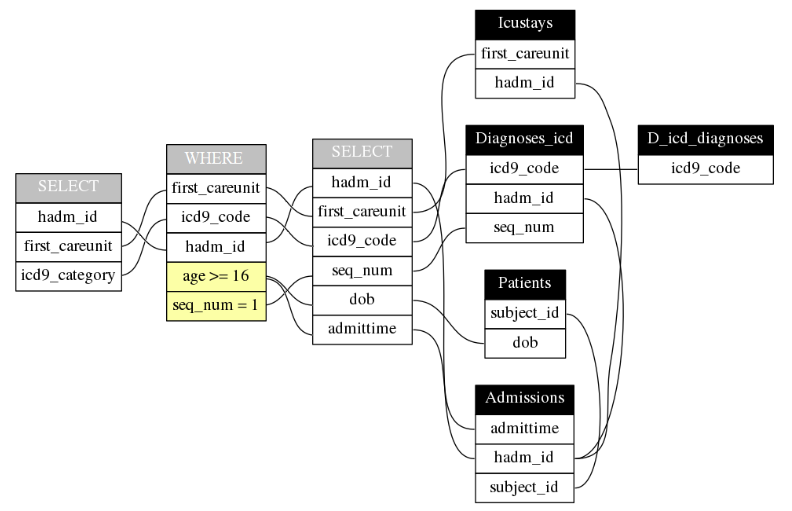

In [15]:
query ="""
SELECT a.hadm_id, i.first_careunit, diag.icd9_code,
       CASE 
            WHEN (lower(LEFT(diag.icd9_code, 1)) = 'e') OR (lower(LEFT(diag.icd9_code, 1)) = 'v')OR (lower(LEFT(diag.icd9_code, 1)) = 'm') 
            THEN 9
            WHEN CAST(LEFT(diag.icd9_code, 3) AS int) >= 0 AND CAST(LEFT(diag.icd9_code, 3) AS int) <= 139 THEN 0
            WHEN CAST(LEFT(diag.icd9_code, 3) AS int) >= 140 AND CAST(LEFT(diag.icd9_code, 3) AS int) <= 239 THEN 1
            WHEN CAST(LEFT(diag.icd9_code, 3) AS int) >= 240 AND CAST(LEFT(diag.icd9_code, 3) AS int) <= 279 THEN 2
            WHEN CAST(LEFT(diag.icd9_code, 3) AS int) >= 390 AND CAST(LEFT(diag.icd9_code, 3) AS int) <= 459 THEN 3
            WHEN CAST(LEFT(diag.icd9_code, 3) AS int) >= 460 AND CAST(LEFT(diag.icd9_code, 3) AS int) <= 519 THEN 4
            WHEN CAST(LEFT(diag.icd9_code, 3) AS int) >= 520 AND CAST(LEFT(diag.icd9_code, 3) AS int) <= 579 THEN 5
            WHEN CAST(LEFT(diag.icd9_code, 3) AS int) >= 580 AND CAST(LEFT(diag.icd9_code, 3) AS int) <= 629 THEN 6
            WHEN CAST(LEFT(diag.icd9_code, 3) AS int) >= 800 AND CAST(LEFT(diag.icd9_code, 3) AS int) <= 959 THEN 7
            WHEN CAST(LEFT(diag.icd9_code, 3) AS int) >= 960 AND CAST(LEFT(diag.icd9_code, 3) AS int) <= 989 THEN 8
            ELSE 9
            END AS icd9_category
FROM mimiciii.admissions a
INNER JOIN mimiciii.icustays i ON a.hadm_id = i.hadm_id
INNER JOIN mimiciii.patients p ON p.subject_id = a.subject_id
INNER JOIN mimiciii.diagnoses_icd diag ON a.hadm_id = diag.hadm_id
INNER JOIN mimiciii.d_icd_diagnoses d_icd ON diag.icd9_code = d_icd.icd9_code
WHERE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16
AND diag.seq_num = 1
"""


query_output = pd.read_sql_query(query,con)
print('Primary ICD-9 cateogry by ICU stay:')
a=query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='CCU']['icd9_category'].value_counts()
b=query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='CSRU']['icd9_category'].value_counts()
c=query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='MICU']['icd9_category'].value_counts()
d=query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='SICU']['icd9_category'].value_counts()
e=query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='TSICU']['icd9_category'].value_counts()
f=query_output.drop_duplicates(['hadm_id'])['icd9_category'].value_counts()
df_num=pd.concat([a,b,c,d,e,f],axis=1)
df_num.fillna(value=0, inplace=True)
df_num.columns = ['CCU', 'CSRU','MICU','SICU','TSICU','Total']
print(df_num.append(df_num.sum(), ignore_index=True))

print('Or in percentages (% of total number in a care unit): ')
a=(a/query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='CCU']['icd9_category'].count())*100
b=(b/query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='CSRU']['icd9_category'].count())*100
c=(c/query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='MICU']['icd9_category'].count())*100
d=(d/query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='SICU']['icd9_category'].count())*100
e=(e/query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='TSICU']['icd9_category'].count())*100
f=(f/query_output.drop_duplicates(['hadm_id'])['icd9_category'].count())*100
df_percent=pd.concat([a,b,c,d,e,f],axis=1)
df_percent.fillna(value=0, inplace=True)
df_percent.columns = ['CCU', 'CSRU','MICU','SICU','TSICU','Total']
print(df_percent.append( df_num.sum() * 100 / df_num.Total.sum(), ignore_index=True))

Primary ICD-9 cateogry by ICU stay:
     CCU  CSRU   MICU  SICU  TSICU  Total
0    314    72   3189   458    173   4206
1    131   241   1434  1225    488   3519
2    108    33    986   178     52   1357
3   5008  7240   2629  2341    729  17947
4    425   133   3382   388    237   4565
5    274   118   2999  1215    494   5100
6    128    14    739    98     35   1014
7    111   188    511   836   3070   4716
8     50     1    582    60     12    705
9    586   702   2870  1195    601   5954
10  7135  8742  19321  7994   5891  49083
Or in percentages (% of total number in a care unit): 
          CCU       CSRU       MICU       SICU      TSICU       Total
0    4.400841   0.823610  16.505357   5.729297   2.936683    8.569158
1    1.836020   2.756806   7.421976  15.323993   8.283823    7.169488
2    1.513665   0.377488   5.103256   2.226670   0.882702    2.764705
3   70.189208  82.818577  13.606956  29.284463  12.374809   36.564595
4    5.956552   1.521391  17.504270   4.853640   4.0230

In [19]:
# Visualization function:
def plot_piechart(data, percentages, labels, save_path=None):
    # Care units and colors:
    care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
    colors=cm.get_cmap('gist_rainbow')
    colors = colors(np.linspace(0, 1, 10))
    colors_brighter = np.zeros((10, 3))
    for row in range(10):
        try:
            c = mc.cnames[colors[row]]
        except:
            c = colors[row]
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
        colors_brighter[row, :] = colorsys.hls_to_rgb(c[0], 1 - 0.7 * (1 - c[1]), c[2]) 
    # Plot pie charts:
    fig, ax = plt.subplots(2, 3, figsize=(26, 24))
    i = 0
    for c in care_units:
        patches, autotexts = ax[i // 3, i % 3].pie(data[i], startangle=90,colors=colors_brighter,)
        circle = plt.Circle( ( 0, 0 ), 0.60,fc='white' )
        ax[i//3, i%3].add_patch(circle)
        ax[i//3, i%3].axis('equal')
        ax[i//3, i%3].set_title(c, fontsize='28', fontweight='roman')
        kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
        for a, p in enumerate(patches):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang)) 
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            end_x = 1.0*np.sign(x)
            if end_x > 0.5:
                end_x = end_x * 0.8 + ((10-a) / 10.0)
            end_y = 1.2 * y
            if (end_y > 0.8) and (i < 3):
                end_y = end_y * 1.2
                if end_x < 0.5:
                    end_x = end_x + (a / 10)
            if (a < 4) and (i < 2):
                end_y = end_y + 0.15 * (a + 1)
            ax[i//3, i%3].annotate(str(round(percentages[a, i], 1)) + '%', xy=(x, y), xytext=(end_x, end_y),
                                   horizontalalignment=horizontalalignment, fontsize='24', **kw)
        i += 1
    fig.delaxes(ax[1][2])
    legend = ax[1][1].legend(labels, loc =(1.5, 0.0), title='Category', prop={'size': 24})
    legend.get_title().set_fontsize('26')
    plt.subplots_adjust(right=1.2)
    if save_path is not None:
        plt.savefig(save_path, dpi=400, bbox_inches = 'tight')

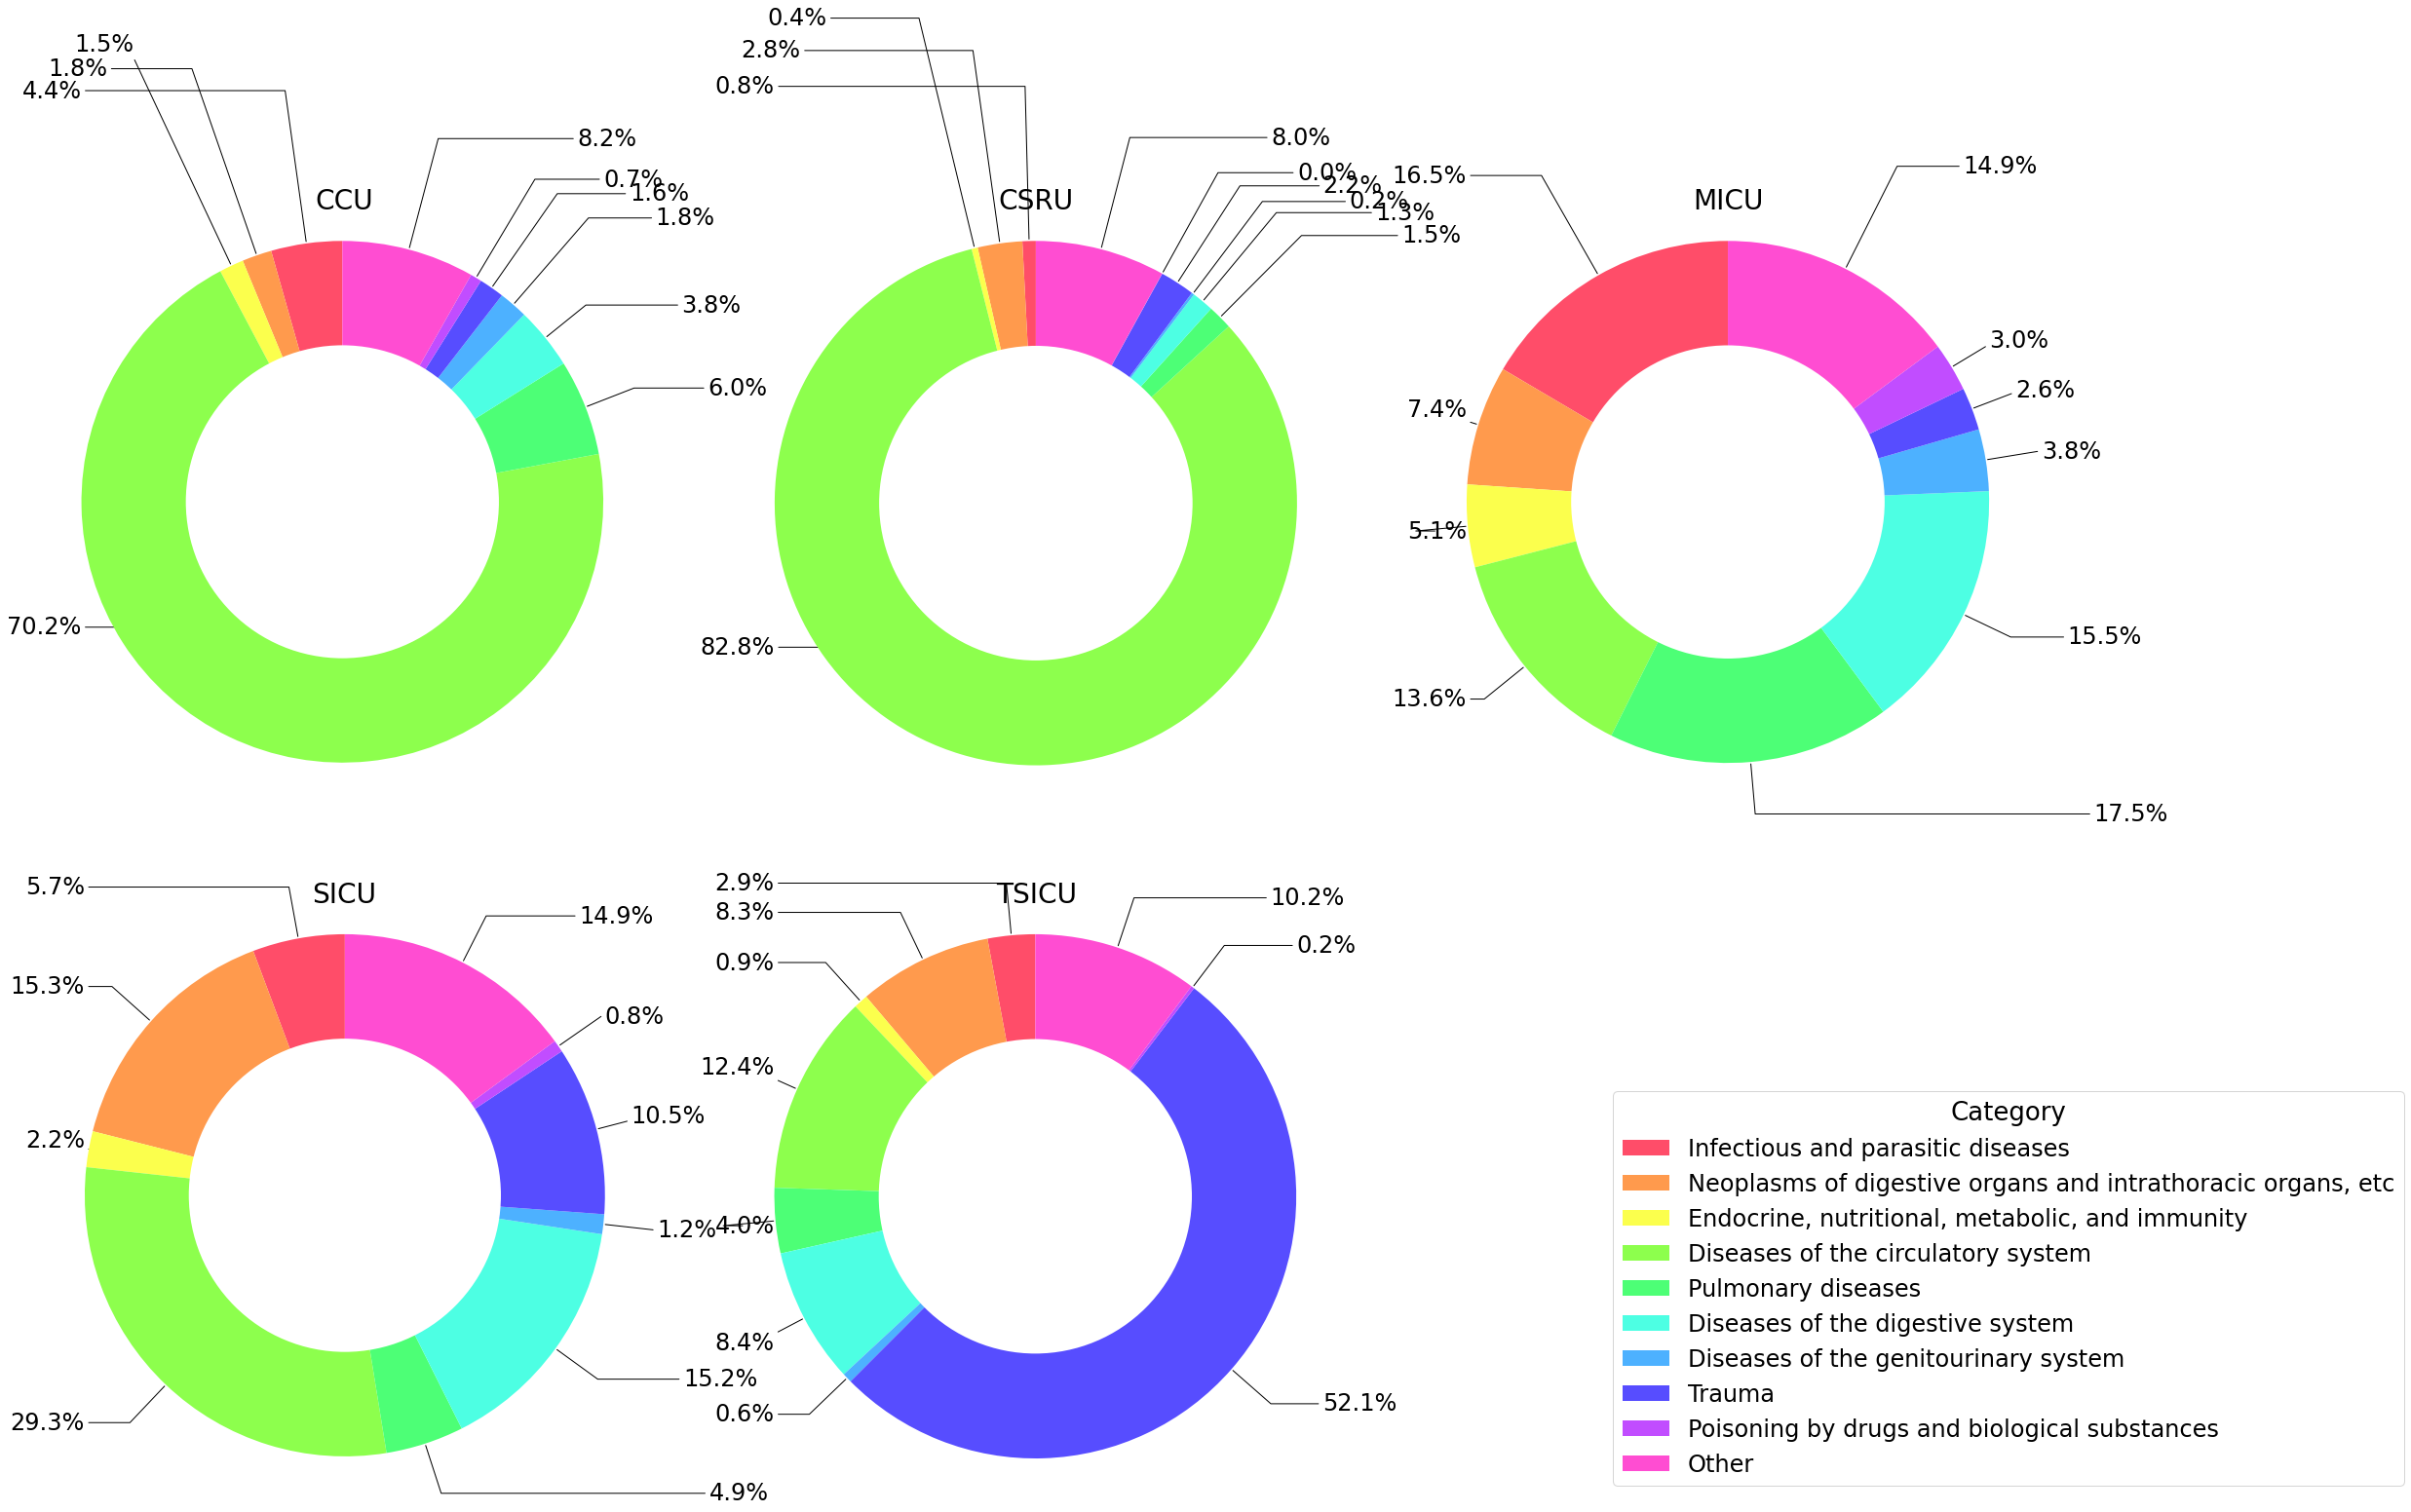

In [20]:
# Visualize with a piechart:
raw_data = []
care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
for c in care_units:
    raw_data.append(df_percent[c])

column_labels = list(
    ['Infectious and parasitic diseases','Neoplasms of digestive organs and intrathoracic organs, etc',
     'Endocrine, nutritional, metabolic, and immunity','Diseases of the circulatory system','Pulmonary diseases',
     'Diseases of the digestive system','Diseases of the genitourinary system','Trauma','Poisoning by drugs and biological substances',
     'Other'])

plot_piechart(raw_data, df_percent.to_numpy(), labels=column_labels, save_path='figures/distribution_icd9_scores_histogram.jpg')